<a href="https://colab.research.google.com/github/AshishRaj04/Spectral-classification-of-Chandrayaan-2-IIRS/blob/main/Spectral_classification_of_Chandrayaan_2_IIRS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install spectral

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.9/212.9 kB 1.5 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive._mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
data_file = "/content/drive/MyDrive/Dataset/Hyperspectral data/data.qub"
header_file = "/content/drive/MyDrive/Dataset/Hyperspectral data/header.hdr"
geometry_file = "/content/drive/MyDrive/Dataset/Hyperspectral data/geometry.csv"

In [4]:
import spectral
import os

In [5]:
data = spectral.io.envi.open(header_file, image=data_file)

In [6]:
hyperspectral_data = data.load()

In [7]:
print(f"Shape of the data: {hyperspectral_data.shape}")

Shape of the data: (9340, 250, 256)


In [20]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten , MaxPooling2D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score , classification_report
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

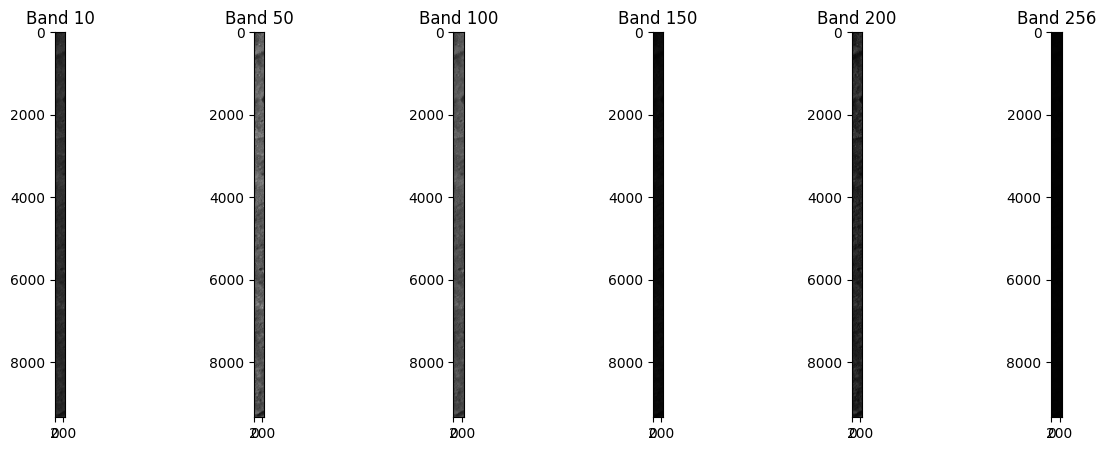

In [ ]:
fig, axes = plt.subplots(1, 6, figsize=(15, 5))

axes[0].imshow(hyperspectral_data[:,:,10], cmap='gray')
axes[0].set_title('Band 10')

axes[1].imshow(hyperspectral_data[:,:,50], cmap='gray')
axes[1].set_title('Band 50')

axes[2].imshow(hyperspectral_data[:,:,100], cmap='gray')
axes[2].set_title('Band 100')

axes[3].imshow(hyperspectral_data[:,:,150], cmap='gray')
axes[3].set_title('Band 150')

axes[4].imshow(hyperspectral_data[:,:,200], cmap='gray')
axes[4].set_title('Band 200')

axes[5].imshow(hyperspectral_data[:,:,255], cmap='gray')
axes[5].set_title('Band 256')

plt.show()

# Data Preparation
* Reshaping
* Normalization

In [9]:
normalized_data = hyperspectral_data / np.max(hyperspectral_data)

In [10]:
flattened_data = normalized_data.reshape(-1, normalized_data.shape[-1])

In [11]:
flattened_data.shape

(2335000, 256)

In [ ]:
print(flattened_data[:10]) # Prints the first 10

[[0.00681401 0.00637074 0.00592747 ... 0.00066645 0.00056592 0.00063337]
 [0.00681401 0.00637074 0.00592747 ... 0.00066645 0.00056592 0.00063337]
 [0.00681401 0.00637074 0.00592747 ... 0.00066645 0.00056592 0.00063337]
 ...
 [0.00331437 0.0033712  0.00342802 ... 0.00046547 0.00038309 0.00039068]
 [0.00738867 0.00678232 0.00617597 ... 0.00046661 0.00077682 0.00094651]
 [0.0087032  0.00805969 0.00741618 ... 0.00044319 0.00048961 0.00045587]]


# Dimensionality Reduction using Principal component analysis

In [29]:
pca = PCA(n_components = 10)
reduces_data = pca.fit_transform(flattened_data)

explained_variance = np.sum(pca.explained_variance_ratio_)
print(f"Explained Variance Ratio by 10 components: {explained_variance}")

Explained Variance Ratio by 10 components: 0.9831173982880049


# Clustering

* Applying **k-mean clustering**

In [12]:
kmean = KMeans(n_clusters=5)

In [13]:
labels = kmean.fit_predict(flattened_data)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [16]:
clustered_image = labels.reshape(hyperspectral_data.shape[0] , hyperspectral_data.shape[1])

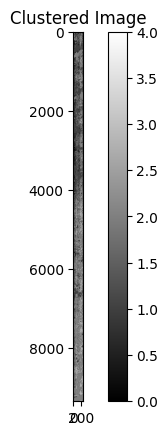

In [17]:
plt.imshow(clustered_image, cmap='gray')
plt.title("Clustered Image")
plt.colorbar()
plt.show()

# Classification
* CNN

In [30]:
X = reduces_data
y = labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
X_train.shape

(1868000, 10)

In [32]:
X_train_cnn = X_train.reshape(-1, 10, 1, 1)
X_test_cnn = X_test.reshape(-1, 10, 1, 1)

In [35]:
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(10 ,1,1) ,  padding='same'),
    MaxPooling2D((2, 1)),
    Conv2D(64, (3, 3), activation='relu',  padding='same'),
    MaxPooling2D((2, 1)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(5, activation='softmax')
])

In [36]:
cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
cnn_model.fit(X_train_cnn, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
46700/46700 [==============================] - 332s 7ms/step - loss: 0.1041 - accuracy: 0.9546 - val_loss: 0.1060 - val_accuracy: 0.9580
Epoch 2/10
46700/46700 [==============================] - 312s 7ms/step - loss: 0.0452 - accuracy: 0.9811 - val_loss: 0.0348 - val_accuracy: 0.9856
Epoch 3/10
46700/46700 [==============================] - 340s 7ms/step - loss: 0.0394 - accuracy: 0.9833 - val_loss: 0.0333 - val_accuracy: 0.9857
Epoch 4/10
46700/46700 [==============================] - 315s 7ms/step - loss: 0.0358 - accuracy: 0.9851 - val_loss: 0.0307 - val_accuracy: 0.9866
Epoch 5/10
46700/46700 [==============================] - 312s 7ms/step - loss: 0.0332 - accuracy: 0.9859 - val_loss: 0.0262 - val_accuracy: 0.9895
Epoch 6/10
46700/46700 [==============================] - 316s 7ms/step - loss: 0.0312 - accuracy: 0.9868 - val_loss: 0.0270 - val_accuracy: 0.9885
Epoch 7/10
46700/46700 [==============================] - 324s 7ms/step - loss: 0.0296 - accuracy: 0.9875 - val_

In [37]:
cnn_eval = cnn_model.evaluate(X_test_cnn, y_test)
print(f'CNN Accuracy: {cnn_eval[1]}')

14594/14594 [==============================] - 39s 3ms/step - loss: 0.0205 - accuracy: 0.9912
CNN Accuracy: 0.9912141561508179
